# Using notes' topic mixtures as features to develop models for predicting length of MV

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scikitplot.classifiers import plot_precision_recall_curve_with_cv, plot_roc_curve_with_cv

## Read data

In [2]:
train_mixture_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2/infer/train.csv'
train_duration_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2/train_bi_vent.txt'
# valid_mixture_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_other_15_thre_d2/infer/validation.csv'
# valid_duration_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_other_15_thre_d2/validation_vent.txt'
test_mixture_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2/infer/test.csv'
test_duration_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2/test_bi_vent.txt'

In [3]:
train_mixtures = pd.read_csv(train_mixture_filename, header=None)
bi_train_duration = pd.read_csv(train_duration_filename, header=None, sep=' ')
bi_train_duration = bi_train_duration[1].astype(int)
# valid_mixtures = pd.read_csv(valid_mixture_filename, header=None)
# valid_duration = pd.read_csv(valid_duration_filename, header=None, sep=' ')
# valid_duration = valid_duration[1].astype(np.float64)
test_mixtures = pd.read_csv(test_mixture_filename, header=None)
bi_test_duration = pd.read_csv(test_duration_filename, header=None, sep=' ')
bi_test_duration = bi_test_duration[1].astype(int)

In [174]:
train_mixtures.shape

(1545, 50)

In [175]:
bi_train_duration.shape

(1545,)

In [151]:
train_mixtures.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,6.169393,0.880430,0.598690,0.362789,0.416184,0.187921,0.665955,0.261223,6.708218,1.185520,...,0.224770,1.037896,0.316181,2.222237,2.559309,1.638421,2.698149,4.288230,0.307073,6.179341
1,1.250451,0.096186,3.431060,0.144998,8.455335,10.792283,3.112868,0.177797,6.234458,0.419704,...,83.139414,0.117779,0.226234,0.141875,0.205148,0.583311,3.067343,0.462541,12.394314,0.822867
2,11.855064,4.588003,150.448018,5.280188,2.262990,1.327328,3.911447,3.677770,25.427030,72.048828,...,3.126892,1.174563,0.841430,84.501553,2.419894,0.414802,1.340032,1.794121,1.088389,4.146183
3,29.423590,52.436662,29.355699,262.250371,2.700544,0.549543,490.783981,0.261389,0.473957,8.493560,...,0.241255,1.967094,0.095113,6.334435,3.305798,0.178678,1.427316,1.488076,0.158686,69.100347
4,9.046872,0.479707,2.254286,187.756879,786.144968,0.252679,0.578828,0.975533,367.764578,1.304707,...,0.140483,2.318918,0.239055,1.616026,0.721336,0.532097,0.405967,6.404681,0.125853,86.830035


In [89]:
normed_train_mixtures = pd.DataFrame(normalize(train_mixtures.iloc[:,0:51], norm='l1', axis=1))
normed_test_mixtures = pd.DataFrame(normalize(test_mixtures.iloc[:,0:51], norm='l1', axis=1))

In [90]:
normed_train_mixtures.shape

(1545, 50)

## Convert to binarized duration

In [94]:
bi_train_duration = (train_duration > 7 * 24).astype(int)
bi_valid_duration = (valid_duration > 7 * 24).astype(int)
bi_test_duration = (test_duration > 7 * 24).astype(int)

## Logistic regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, average_precision_score, precision_recall_curve, accuracy_score

In [5]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=200)

In [6]:
lr.fit(train_mixtures, bi_train_duration)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
test_predictions_lr = lr.predict(test_mixtures)

In [8]:
print(average_precision_score(bi_test_duration, test_predictions_lr))
print(classification_report(bi_test_duration, test_predictions_lr))

0.5344561688311689
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        89
           1       0.61      0.60      0.60        65

    accuracy                           0.67       154
   macro avg       0.66      0.66      0.66       154
weighted avg       0.67      0.67      0.67       154



In [9]:
test_proba_lr = lr.predict_proba(test_mixtures)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(bi_test_duration, test_proba_lr, pos_label=1)

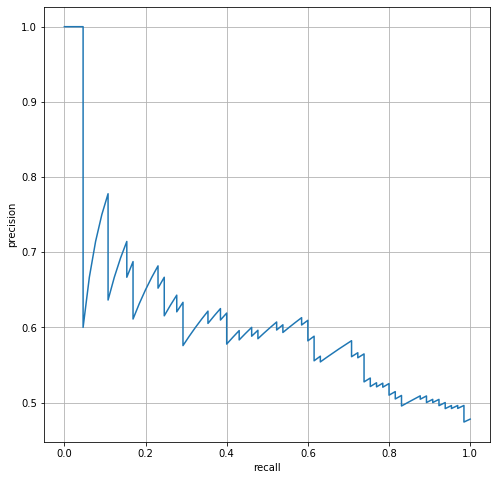

In [12]:
plt.figure(figsize=(8, 8))
plt.plot(lr_recall, lr_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid()

## Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB

In [24]:
GNB = GaussianNB()

In [25]:
GNB.fit(train_mixtures, bi_train_duration)

GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
test_predictions_GNB = GNB.predict(test_mixtures)

In [27]:
print(average_precision_score(bi_test_duration, test_predictions_GNB))
print(classification_report(bi_test_duration, test_predictions_GNB))

0.45545224006762464
              precision    recall  f1-score   support

           0       0.65      0.46      0.54        89
           1       0.47      0.66      0.55        65

    accuracy                           0.55       154
   macro avg       0.56      0.56      0.55       154
weighted avg       0.58      0.55      0.54       154



## SVM

### Linear SVM

In [28]:
from sklearn.svm import LinearSVC

In [29]:
lsvm = LinearSVC()

In [30]:
lsvm.fit(train_mixtures, bi_train_duration)

/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [31]:
test_predictions_lsvm = lsvm.predict(test_mixtures)

In [33]:
print(average_precision_score(bi_test_duration, test_predictions_lsvm))
print(classification_report(bi_test_duration, test_predictions_lsvm))

0.4116853734500793
              precision    recall  f1-score   support

           0       0.56      0.54      0.55        89
           1       0.40      0.42      0.41        65

    accuracy                           0.49       154
   macro avg       0.48      0.48      0.48       154
weighted avg       0.49      0.49      0.49       154



### Non-linear SVM

In [34]:
from sklearn.svm import SVC

In [35]:
svm = SVC()

In [36]:
svm.fit(train_mixtures, bi_train_duration)

/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [38]:
test_predictions_svm = svm.predict(test_mixtures)

In [40]:
print(average_precision_score(bi_test_duration, test_predictions_svm))
print(classification_report(bi_test_duration, test_predictions_svm))

0.5020979020979022
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        89
           1       1.00      0.14      0.24        65

    accuracy                           0.64       154
   macro avg       0.81      0.57      0.50       154
weighted avg       0.78      0.64      0.54       154



## Grid Search LR
Logistic regression seems to be the best classifier. See how good it can be.

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
estimator = LogisticRegression(solver='liblinear', class_weight='balanced')

In [58]:
hyperparams = {
    'C': np.arange(0.6, 1.0, step=0.01),
    'max_iter': [100, 200, 300]
              }

In [59]:
searcher = GridSearchCV(estimator=estimator, n_jobs=12, param_grid=hyperparams, scoring='average_precision', cv=5)

In [60]:
searcher.fit(train_mixtures, bi_train_duration)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=12,
             param_grid={'C': array([0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 ,
       0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81,
       0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92,
       0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                         'max_iter

In [61]:
print(searcher.best_params_)

{'C': 0.8800000000000002, 'max_iter': 100}


In [62]:
print(searcher.best_score_)

0.5081135923225946


In [63]:
test_predictions_lrbest = searcher.best_estimator_.predict(test_mixtures)

In [64]:
print(average_precision_score(bi_test_duration, test_predictions_lrbest))
print(classification_report(bi_test_duration, test_predictions_lrbest))

0.5344561688311689
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        89
           1       0.61      0.60      0.60        65

    accuracy                           0.67       154
   macro avg       0.66      0.66      0.66       154
weighted avg       0.67      0.67      0.67       154



In [65]:
test_proba_lrbest = searcher.best_estimator_.predict_proba(test_mixtures)[:, 1]
precision, recall, _ = precision_recall_curve(bi_test_duration, test_proba_lrbest, pos_label=1)

In [33]:
import matplotlib.pyplot as plt

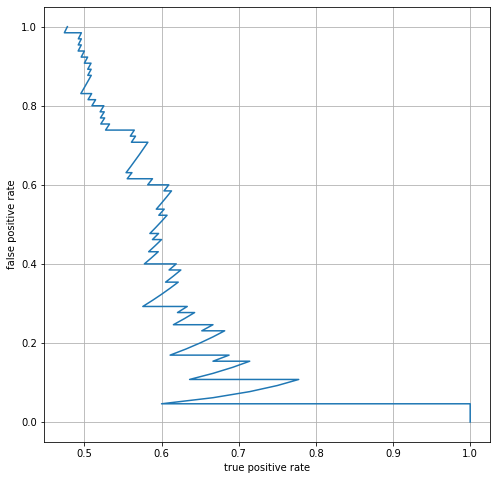

In [69]:
plt.figure(figsize=(8, 8))
plt.plot(precision, recall)
plt.xlabel('true positive rate')
plt.ylabel('false positive rate')
plt.grid()

## Try AdaBoost

In [1]:
from sklearn.ensemble import AdaBoostClassifier

In [6]:
ada = AdaBoostClassifier(base_estimator=LogisticRegression(solver='liblinear', C=1.5, max_iter=100, class_weight='balanced'), random_state=1)

In [7]:
ada.fit(train_mixtures, bi_train_duration)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=1.5,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='warn',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=None,
                                                     solver='liblinear',
                                                     tol=0.0001, verbose=0,
                                                     warm_start=False),
                   learning_r

In [9]:
test_predictions_ada = ada.predict(test_mixtures)

In [28]:
print(average_precision_score(bi_test_duration, test_predictions_ada))
print(classification_report(bi_test_duration, test_predictions_ada))

0.5215204150688022
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        89
           1       0.60      0.57      0.58        65

    accuracy                           0.66       154
   macro avg       0.65      0.64      0.64       154
weighted avg       0.65      0.66      0.65       154



## Try MLP (non-linear classifier)

In [93]:
from sklearn.neural_network import MLPClassifier

In [14]:
mlp = MLPClassifier(hidden_layer_sizes=(40, 30),
                   activation='relu',
#                    solver='lbfgs',
                   early_stopping=False,
                   max_iter=300,
                   random_state=1,
                   n_iter_no_change=20,
                   verbose=False)

In [17]:
mlp.fit(train_mixtures, bi_train_duration)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(40, 30), learning_rate='constant',
              learning_rate_init=0.001, max_iter=300, momentum=0.9,
              n_iter_no_change=20, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [18]:
mlp.n_iter_

213

In [19]:
test_predictions_mlp = mlp.predict(test_mixtures)

In [20]:
print(average_precision_score(bi_test_duration, test_predictions_mlp))
print(classification_report(bi_test_duration, test_predictions_mlp))

0.9293030046876202
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        89
           1       0.95      0.95      0.95        65

    accuracy                           0.96       154
   macro avg       0.96      0.96      0.96       154
weighted avg       0.96      0.96      0.96       154



In [78]:
test_proba_mlp = mlp.predict_proba(test_mixtures)[:, 1]
mlp_precision, mlp_recall, _ = precision_recall_curve(bi_test_duration, test_proba_mlp, pos_label=1)

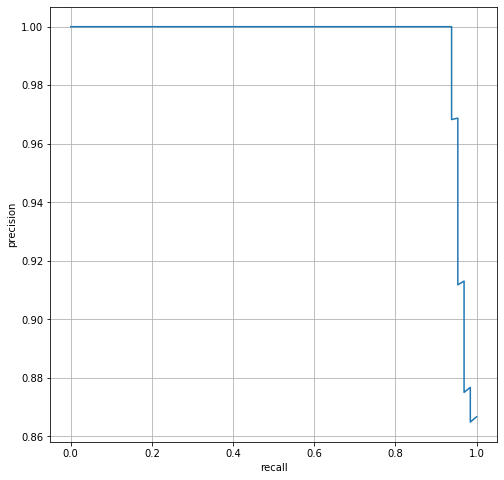

In [79]:
plt.figure(figsize=(8, 8))
plt.plot(mlp_recall, mlp_precision)
# plt.fill_between(mlp_recall, mlp_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid()

## Cross validation

In [31]:
import os
from sklearn.preprocessing import normalize
import random

In [129]:
data_path = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2_cv'

In [130]:
fold_dfs = [pd.read_csv(os.path.join(data_path, 'infer', 'f' + str(idx) + '.csv'), header=None) for idx in range(1, 6)]

In [131]:
fold_dfs = [pd.DataFrame(normalize(fold_df.iloc[:,0:], norm='l1', axis=1)) for fold_df in fold_dfs]

In [132]:
fold_dfs[0].head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000102,0.000710,0.005845,0.000760,0.005574,0.023033,0.002161,0.010837,0.028338,0.099127,...,0.010616,0.000695,0.034566,0.016902,0.006617,0.007723,0.000816,0.091156,0.000708,0.005645
1,0.001703,0.000916,0.000171,0.001579,0.000460,0.000491,0.000152,0.001079,0.000461,0.000586,...,0.000279,0.044830,0.000267,0.001114,0.000692,0.001185,0.000411,0.000647,0.005836,0.000492
2,0.000225,0.014341,0.020419,0.002033,0.006820,0.009159,0.000238,0.161934,0.030551,0.019383,...,0.004070,0.000186,0.004685,0.029209,0.001002,0.018981,0.000246,0.005228,0.000678,0.021791
3,0.027494,0.000727,0.007390,0.000590,0.012896,0.000679,0.001078,0.002600,0.002665,0.002715,...,0.151078,0.000464,0.002285,0.135078,0.046876,0.000712,0.000072,0.006665,0.020374,0.121664
4,0.010215,0.050714,0.004430,0.004983,0.001867,0.001266,0.007602,0.001070,0.012861,0.005619,...,0.000331,0.002321,0.003944,0.000475,0.008236,0.097787,0.039732,0.002001,0.002745,0.003233


In [133]:
bi_durations = [pd.read_csv(os.path.join(data_path, 'f' + str(idx) + '_bi_vent.txt') , header=None, sep=' ') for idx in range(1, 6)] 
bi_durations = [bi_duration[1].astype(int) for bi_duration in bi_durations]

In [134]:
bi_durations[0]

0      0
1      1
2      0
3      1
4      1
      ..
273    0
274    1
275    1
276    0
277    0
Name: 1, Length: 278, dtype: int64

### plotting function for cv

In [167]:
def cv_curve(y_true, y_prob, n_thres=100, mode='prc'):
    epsilon = 1e-5 # avoid division by zero
    if mode not in ['prc', 'roc']:
        raise Exception('mode should be prc or roc')
    precs = []
    recalls = []
    tprs = []
    fprs = []
    for thre in np.linspace(0, 1, n_thres):
        tp = np.sum([y_prob[idx] > thre for idx in range(len(y_prob)) if y_true[idx] == 1])
        tn = np.sum([y_prob[idx] < thre for idx in range(len(y_prob)) if y_true[idx] == 0])
        fp = np.sum([y_prob[idx] > thre for idx in range(len(y_prob)) if y_true[idx] == 0])
        fn = np.sum([y_prob[idx] < thre for idx in range(len(y_prob)) if y_true[idx] == 1])
        if mode == 'prc':
            precs.append(tp / (tp + fp + epsilon))
            recalls.append(tp / (tp + fn + epsilon))
        else:
            tprs.append(tp / (tp + fn + epsilon))
            fprs.append(fp / (fp + tn + epsilon))
    if mode == 'prc':
        return recalls, precs
    else:
        return fprs, tprs

### prepare grid search data

In [135]:
gs_mixtures = pd.concat(fold_dfs, ignore_index=True)

In [136]:
gs_mixtures.shape

(1391, 50)

In [137]:
gs_bi_durations = pd.concat(bi_durations, ignore_index=True)

In [138]:
gs_bi_durations.shape

(1391,)

In [139]:
indices = list(range(gs_bi_durations.shape[0]))
random.shuffle(indices)
k_fold_indices = []
size = np.ceil(gs_bi_durations.shape[0] / 5)
for idx in range(5):
    k_fold_indices.append(indices[int(idx * size): int(min((idx + 1) * size, gs_bi_durations.shape[0]))])

In [140]:
shuffled_fold_dfs = [gs_mixtures.iloc[k_fold_indices[idx]] for idx in range(5)]
shuffled_bi_durations = [gs_bi_durations.iloc[k_fold_indices[idx]] for idx in range(5)]

### MLP

In [95]:
auprc = []
acc = []
for idx in range(5):
    cv_test_mixture = shuffled_fold_dfs[idx].copy()
    bi_test_duration = shuffled_bi_durations[idx].copy()
    train_fold_dfs = shuffled_fold_dfs.copy()
    del train_fold_dfs[idx]
    cv_train_mixtures = pd.concat(train_fold_dfs)
    bi_train_durations = shuffled_bi_durations.copy()
    del bi_train_durations[idx]
    bi_train_durations = pd.concat(bi_train_durations)

    mlp = MLPClassifier(hidden_layer_sizes=(40, 30),
                   activation='relu',
#                    solver='lbfgs',
                   early_stopping=False,
                   max_iter=1000,
#                    random_state=1,
                   n_iter_no_change=40,
                   verbose=False)
    mlp.fit(cv_train_mixtures, bi_train_durations)
    test_predictions_mlp = mlp.predict(cv_test_mixture)
    auprc.append(average_precision_score(bi_test_duration, test_predictions_mlp))
    acc.append(accuracy_score(bi_test_duration, test_predictions_mlp))
    print('auprc:', auprc[-1])
    print('acc:', acc[-1])
    
print('mean auprc:', np.mean(auprc))
print('mean acc:', np.mean(acc))

auprc: 0.3918392124682065
acc: 0.5770609318996416
auprc: 0.510431361484686
acc: 0.6057347670250897
auprc: 0.47098082103341576
acc: 0.6093189964157706
auprc: 0.4119645961751225
acc: 0.5448028673835126
auprc: 0.475380078964466
acc: 0.5854545454545454
mean auprc: 0.45211921402517935
mean acc: 0.5844744216357121


In [98]:
mlp = MLPClassifier(hidden_layer_sizes=(40, 30),
                   activation='relu',
#                    solver='lbfgs',
                   early_stopping=False,
                   max_iter=800,
#                    random_state=1,
                   n_iter_no_change=40,
                   verbose=False)

/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) re

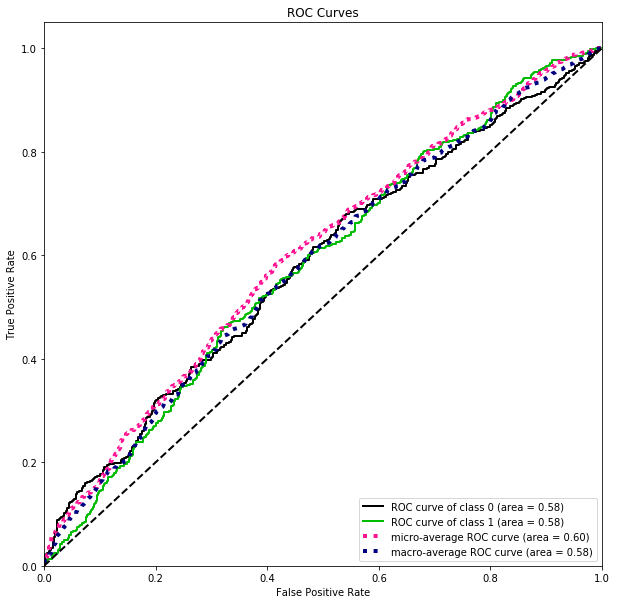

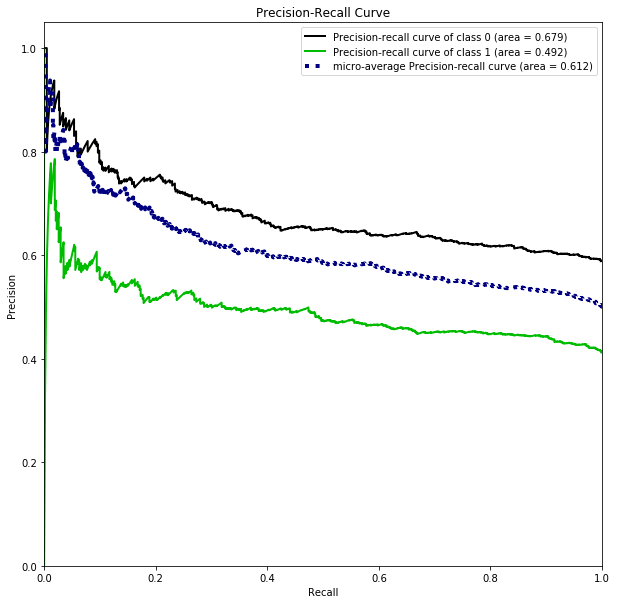

In [99]:
plot_roc_curve_with_cv(mlp, np.array(gs_mixtures), np.array(gs_bi_durations), do_cv=True, cv=5, figsize=(10, 10))
plot_precision_recall_curve_with_cv(mlp, np.array(gs_mixtures), np.array(gs_bi_durations), do_cv=True, cv=5, figsize=(10, 10))

### AdaBoost

In [141]:
from sklearn.ensemble import AdaBoostClassifier

In [142]:
auprc = []
acc = []
for idx in range(5):
    cv_test_mixture = shuffled_fold_dfs[idx].copy()
    bi_test_duration = shuffled_bi_durations[idx].copy()
    train_fold_dfs = shuffled_fold_dfs.copy()
    del train_fold_dfs[idx]
    cv_train_mixtures = pd.concat(train_fold_dfs)
    bi_train_durations = shuffled_bi_durations.copy()
    del bi_train_durations[idx]
    bi_train_durations = pd.concat(bi_train_durations)

    ada = AdaBoostClassifier(base_estimator=LogisticRegression(solver='lbfgs', \
                                                               C=1.42, \
                                                               max_iter=100, \
                                                               class_weight='balanced'))
    ada.fit(cv_train_mixtures, bi_train_durations)
    test_predictions_ada = ada.predict(cv_test_mixture)
    auprc.append(average_precision_score(bi_test_duration, test_predictions_ada))
    acc.append(accuracy_score(bi_test_duration, test_predictions_ada))
    print('auprc:', auprc[-1])
    print('acc:', acc[-1])
    
print('mean auprc:', np.mean(auprc))
print('mean acc:', np.mean(acc))

auprc: 0.434295123355048
acc: 0.5591397849462365
auprc: 0.5038110191264631
acc: 0.6451612903225806
auprc: 0.41225485015807595
acc: 0.5268817204301075
auprc: 0.46285514468047906
acc: 0.5340501792114696
auprc: 0.47299308878256247
acc: 0.5963636363636363
mean auprc: 0.4572418452205257
mean acc: 0.5723193222548061


In [94]:
ada = AdaBoostClassifier(base_estimator=LogisticRegression(solver='lbfgs', \
                                                               C=1.16, \
                                                               max_iter=100, \
                                                               class_weight='balanced'))

/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


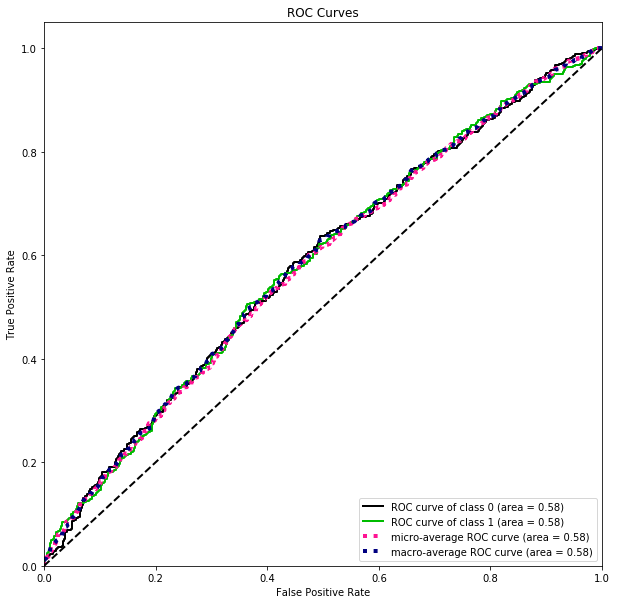

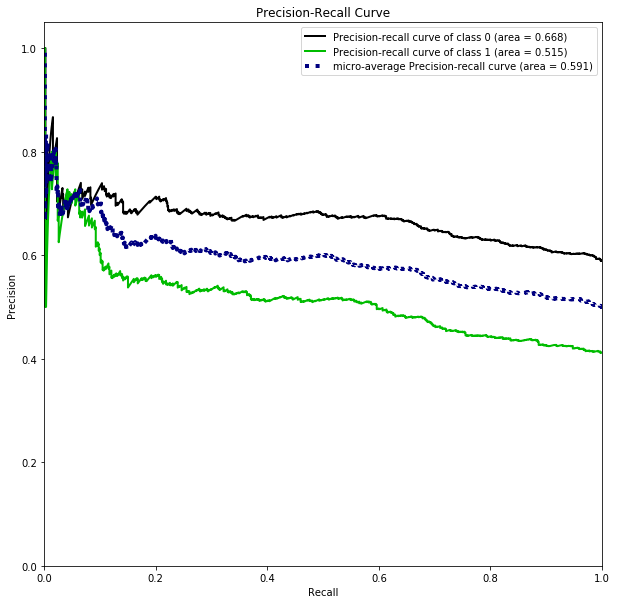

In [95]:
plot_roc_curve_with_cv(ada, np.array(gs_mixtures), np.array(gs_bi_durations), do_cv=True, cv=5, figsize=(10, 10))
plot_precision_recall_curve_with_cv(ada, np.array(gs_mixtures), np.array(gs_bi_durations), do_cv=True, cv=5, figsize=(10, 10))

### LR

In [175]:
auprc = []
acc = []
precs = []
recalls = []
tprs = []
fprs = []

for idx in range(5):
    cv_test_mixture = shuffled_fold_dfs[idx].copy()
    bi_test_duration = shuffled_bi_durations[idx].copy()
    train_fold_dfs = shuffled_fold_dfs.copy()
    del train_fold_dfs[idx]
    cv_train_mixtures = pd.concat(train_fold_dfs)
    bi_train_durations = shuffled_bi_durations.copy()
    del bi_train_durations[idx]
    bi_train_durations = pd.concat(bi_train_durations)

    lr = LogisticRegression(class_weight='balanced', C=1, solver='lbfgs', max_iter=1000, penalty='l2')
    
    lr.fit(cv_train_mixtures, bi_train_durations)
    test_predictions_lr = lr.predict(cv_test_mixture)
    test_probs_lr = lr.predict_proba(cv_test_mixture)[:, 1]
    recall, prec = cv_curve(list(bi_test_duration), list(test_probs_lr), n_thres=100, mode='prc')
    precs.append(prec)
    recalls.append(recall)
    fpr, tpr = cv_curve(list(bi_test_duration), list(test_probs_lr), n_thres=100, mode='roc')
    fprs.append(fpr)
    tprs.append(tpr)
    
    auprc.append(average_precision_score(bi_test_duration, test_predictions_lr))
    acc.append(accuracy_score(bi_test_duration, test_predictions_lr))
    print('auprc:', auprc[-1])
    print('acc:', acc[-1])
    
print('mean auprc:', np.mean(auprc))
print('mean acc:', np.mean(acc))

auprc: 0.44472118346721734
acc: 0.5842293906810035
auprc: 0.5022210187719583
acc: 0.6451612903225806
auprc: 0.4146594747662281
acc: 0.5376344086021505
auprc: 0.49961935775271726
acc: 0.5949820788530465
auprc: 0.46547859962872906
acc: 0.5927272727272728
mean auprc: 0.46533992687737
mean acc: 0.5909468882372109


In [176]:
mean_recall = np.mean(recalls, axis=0)
mean_prec = np.mean(precs, axis=0)
mean_fpr = np.mean(fprs, axis=0)
mean_tpr = np.mean(tprs, axis=0)

In [177]:
prc_df = pd.DataFrame(np.transpose([mean_recall, mean_prec]))
prc_df.columns = ['RECALL', 'PRECISION']
roc_df = pd.DataFrame(np.transpose([mean_fpr, mean_tpr]))
roc_df.columns = ['FPR', 'TPR']

In [181]:
prc_df.to_csv('/home/mcb/li_lab/zwen8/data/mimic/single_multi_compare/prc_multi.csv', index=None)
roc_df.to_csv('/home/mcb/li_lab/zwen8/data/mimic/single_multi_compare/roc_multi.csv', index=None)

In [187]:
np.sum([(mean_prec[idx+1] + mean_prec[idx]) * - (mean_recall[idx+1] - mean_recall[idx]) for idx in range(99)]) / 2

0.5164631499565973

In [189]:
np.sum([(mean_tpr[idx+1] + mean_tpr[idx]) * - (mean_fpr[idx+1] - mean_fpr[idx]) for idx in range(99)]) / 2

0.6112891798254053

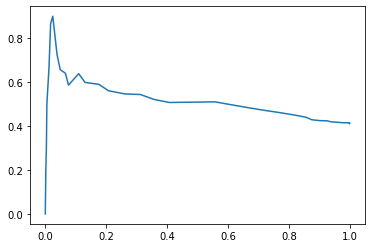

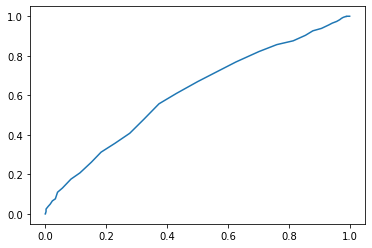

In [179]:
plt.plot(mean_recall, mean_prec)
plt.figure()
plt.plot(mean_fpr, mean_tpr)

In [144]:
lr = LogisticRegression(class_weight='balanced', C=1.42, solver='lbfgs', max_iter=1000, penalty='l2')

/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


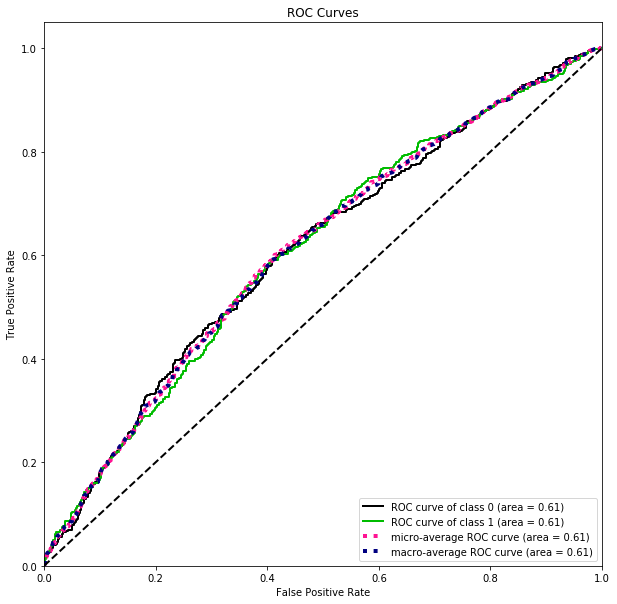

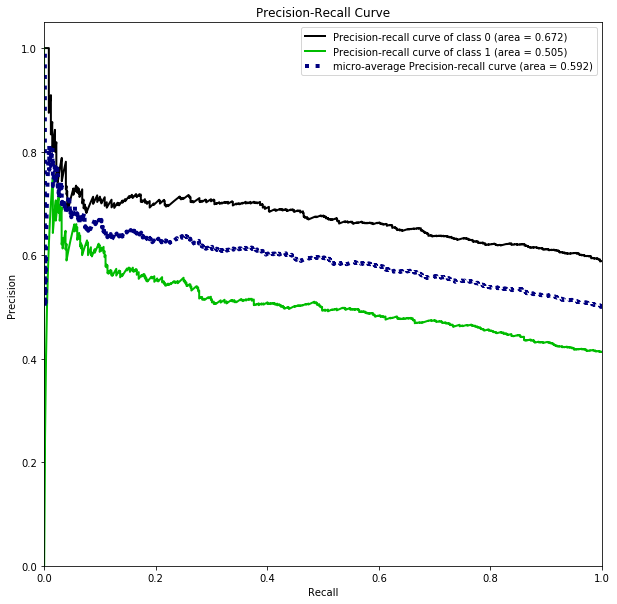

In [145]:
plot_roc_curve_with_cv(lr, np.array(gs_mixtures), np.array(gs_bi_durations), do_cv=True, cv=5, figsize=(10, 10))
plot_precision_recall_curve_with_cv(lr, np.array(gs_mixtures), np.array(gs_bi_durations), do_cv=True, cv=5, figsize=(10, 10))

### grid serach MLP

In [48]:
from sklearn.model_selection import GridSearchCV

In [118]:
mlp_estimator = MLPClassifier(activation='relu',
                   random_state=1,
                   n_iter_no_change=40,
                   verbose=False)

In [119]:
mlp_hyperparams = {'hidden_layer_sizes': [(l1, 20) for l1 in [40, 30]],
              'early_stopping': [True, False],
              'max_iter': [int(num) for num in range(300, 1000, 100)]}

In [120]:
mlp_searcher = GridSearchCV(estimator=mlp_estimator,
                       param_grid=mlp_hyperparams,
                       scoring='average_precision',
                       n_jobs=14,
                       cv=5)

In [121]:
mlp_searcher.fit(gs_mixtures, gs_bi_durations)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=40,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=1, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=14,
             param_grid={'early_stopping': [True, False],
             

In [122]:
mlp_searcher.best_params_

{'early_stopping': True, 'hidden_layer_sizes': (40, 20), 'max_iter': 300}

In [123]:
mlp_searcher.best_score_

0.4998967564255863

### grid search LR

In [67]:
from sklearn.model_selection import GridSearchCV

In [123]:
lr_estimator = LogisticRegression(class_weight='balanced', max_iter=1000)

In [124]:
lr_hyperparams = {
    'C': np.arange(1.2, 1.6, step=0.01),
    'solver': ['liblinear', 'lbfgs'],
              }

In [125]:
lr_searcher = GridSearchCV(estimator=lr_estimator, n_jobs=12, param_grid=lr_hyperparams, scoring='average_precision', cv=5)

In [126]:
lr_searcher.fit(gs_mixtures, gs_bi_durations)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=12,
             param_grid={'C': array([1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 ,
       1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41,
       1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52,
       1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6 ]),
                         'solver

In [127]:
lr_searcher.best_params_

{'C': 1.4200000000000002, 'solver': 'lbfgs'}

In [128]:
lr_searcher.best_score_

0.5003251783786732